In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.utils.class_weight import compute_class_weight
import mlflow
import mlflow.sklearn

In [3]:
df = pd.read_csv("/root/mlops_projects/FinancialSentiment_prediction/Datasets/Financial_data.csv")

In [4]:
df.head(10)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,neutral
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",neutral
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
5,$SPY wouldn't be surprised to see a green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,neutral
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,neutral
8,Kone 's net sales rose by some 14 % year-on-ye...,neutral
9,The Stockmann department store will have a tot...,neutral


In [5]:
df.duplicated().sum()

np.int64(520)

In [6]:
df.drop_duplicates(keep="first",inplace=True)

In [7]:
# Map sentiments to numerical labels
sentiment_map = {'positive': 2, 'neutral': 1, 'negative': 0}
df['Sentiment'] = df['Sentiment'].map(sentiment_map)

In [8]:
df.head(10)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,1
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",0
2,"For the last quarter of 2010 , Componenta 's n...",1
3,According to the Finnish-Russian Chamber of Co...,1
4,The Swedish buyout firm has sold its remaining...,1
5,$SPY wouldn't be surprised to see a green close,2
6,Shell's $70 Billion BG Deal Meets Shareholder ...,1
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,1
8,Kone 's net sales rose by some 14 % year-on-ye...,1
9,The Stockmann department store will have a tot...,1


In [9]:
df.shape

(5322, 2)

In [10]:
x = df["Sentence"]
y = df["Sentiment"]
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [11]:
X_train.shape

(4257,)

In [12]:
print(X_train)

1905    CompaniesActelion shares hit record on Shire t...
2764    The investment will be worth approximately EUR...
194     Stora is due to release its fourth-quarter and...
3600    Fiskars , a 360-year-old global business best ...
5271    Finland 's leading metals group Outokumpu said...
                              ...                        
5729    Most of the dividend will go to the Grimaldi f...
2408    The Estonian electronic components factory , E...
1473    The period 's sales dropped to EUR 30.6 millio...
1371                                     $WYNN big bounce
2157    In a letter to Economic Affairs Minister , the...
Name: Sentence, Length: 4257, dtype: object


In [13]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')
  

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [14]:
from nlpaug import Augmenter
import nlpaug.augmenter.word as naw
aug =naw.SynonymAug(aug_src='wordnet')

#augment only minority classes
for label in [0,2]:
    class_samples = X_train[y_train == label]
    for text in class_samples[:int(0.5*len(class_samples))]:
        augumented = aug.augment(text)
        X_train = np.append(X_train,augumented)
        y_train = np.append(y_train,label)

In [15]:
print("X_train length :",X_train.size)
print("y_train length :",y_train.size)

X_train length : 4991
y_train length : 4991


In [16]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [17]:
# Enhanced text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    stop_words = set(stopwords.words('english')) - {'not', 'no', 'but', 'never', 'very', 'above', 'below', 'up', 'down', 'over','very', 'bullish', 'bearish', 'buy', 'sell', 'strong', 'weak'}
    #stop_words.update(['$', '%', '&', '@'])
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    return ' '.join(tokens)

In [18]:
X_train = pd.Series(X_train)
X_train = X_train.apply(preprocess_text)

In [19]:
X_test = X_test.apply(preprocess_text)

In [20]:
print(X_train)

0       companiesactelion share hit record shire takeo...
1                   investment worth approximately eur mn
2       stora due release fourthquarter fullyear earni...
3       fiskars yearold global business best known ora...
4       finland leading metal group outokumpu said fou...
                              ...                        
4986    finnish financial group aktia operating net pr...
4987    joerazorback time ane mean aapl miss generally...
4988    finnish rautaruukki ha awarded contract bridge...
4989    asking finnish medium company alma medium news...
4990    finnish investing chemical group neomarkka oyj...
Length: 4991, dtype: object


In [21]:
mlflow.set_tracking_uri("http://ec2-43-205-211-96.ap-south-1.compute.amazonaws.com:5000/")

In [ ]:
# def train_evaluate_dt(vectorizer, vectorizer_name):
#     X_train_vec = vectorizer.fit_transform(X_train)
#     X_test_vec = vectorizer.transform(X_test)
    
#     # Grid search for hyperparameter tuning
#     param_grid = {
#         'max_depth': [5, 10, 20, None],
#         'min_samples_split': [2, 5, 10],
#         'min_samples_leaf': [1, 2, 4]
#     }
#     dt_model = DecisionTreeClassifier(random_state=42)
#     grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring='balanced_accuracy', n_jobs=4)
#     grid_search.fit(X_train_vec, y_train)
    
#     # Best model
#     best_dt = grid_search.best_estimator_
#     print(f"\nBest parameters for {vectorizer_name}: {grid_search.best_params_}")
    
#     # Predict
#     y_pred = best_dt.predict(X_test_vec)
    
#     # Evaluate
#     accuracy = accuracy_score(y_test, y_pred)
#     balanced_acc = balanced_accuracy_score(y_test, y_pred)
#     print(f"\nResults for {vectorizer_name}:")
#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Balanced Accuracy: {balanced_acc:.4f}")
#     print("\nClassification Report:")
#     print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))
    
#     # Confusion matrix
#     cm = confusion_matrix(y_test, y_pred)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
#     plt.title(f'Confusion Matrix - {vectorizer_name}')
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.show()
#     # Feature importance
#     feature_importance = pd.DataFrame({
#         'feature': vectorizer.get_feature_names_out(),
#         'importance': best_dt.feature_importances_
#     }).sort_values(by='importance', ascending=False).head(10)
#     print(f"\nTop 10 important features for {vectorizer_name}:")
#     print(feature_importance)
    
#     return best_dt, vectorizer

In [22]:
from mlflow.tracking import MlflowClient 
client = MlflowClient()

# Get all experiments (returns List[Experiment])
experiments_id = client.search_experiments()

for exp in experiments_id:
    print(f"Experiment name :{exp.name} and id:{exp.experiment_id}")

Experiment name :DecissionTree_model and id:393294509303202776
Experiment name :Sentiment_Analysis_LSTM_TFIDF and id:887211302989745420
Experiment name :ML_model_dataaug and id:918242205499858319
Experiment name :baseline_ML_model and id:408458959843314322
Experiment name :Navie_bayes_experiment and id:639483181163671325
Experiment name :Default and id:0


In [23]:
mlflow.set_experiment(experiment_name="DecissionTree_model")

<Experiment: artifact_location='s3://s3bucmlflow/393294509303202776', creation_time=1757419367471, experiment_id='393294509303202776', last_update_time=1757419367471, lifecycle_stage='active', name='DecissionTree_model', tags={}>

In [24]:
def train_evaluate_dt(vectorizer, vectorizer_name):
    # Start an MLflow run
    with mlflow.start_run():
        # Log the vectorizer name as a parameter
        mlflow.log_param("vectorizer_name", vectorizer_name)

        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)
        
        # Grid search for hyperparameter tuning
        param_grid = {
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        dt_model = DecisionTreeClassifier(random_state=42)
        grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring='balanced_accuracy', n_jobs=4)
        grid_search.fit(X_train_vec, y_train)
        
        # Best model
        best_dt = grid_search.best_estimator_
        print(f"\nBest parameters for {vectorizer_name}: {grid_search.best_params_}")
        
        # Log the best hyperparameters from the grid search
        mlflow.log_params(grid_search.best_params_)

        # Predict
        y_pred = best_dt.predict(X_test_vec)
        
        # Evaluate
        accuracy = accuracy_score(y_test, y_pred)
        balanced_acc = balanced_accuracy_score(y_test, y_pred)
        
        # Log the evaluation metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("balanced_accuracy", balanced_acc)

        print(f"\nResults for {vectorizer_name}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Balanced Accuracy: {balanced_acc:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))

        # Log classification report as an artifact
        report_dict = classification_report(y_test, y_pred, output_dict=True, target_names=['negative', 'neutral', 'positive'])
        report_df = pd.DataFrame(report_dict).transpose()
        report_df.to_csv("classification_report.csv")
        mlflow.log_artifact("classification_report.csv")

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
        plt.title(f'Confusion Matrix - {vectorizer_name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(f"confusion_matrix_{vectorizer_name}.png") # Save figure
        plt.show()

        # Log the confusion matrix plot as an artifact
        mlflow.log_artifact(f"confusion_matrix_{vectorizer_name}.png")

        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': vectorizer.get_feature_names_out(),
            'importance': best_dt.feature_importances_
        }).sort_values(by='importance', ascending=False).head(10)
        
        # Log feature importance as an artifact
        feature_importance.to_csv("feature_importance.csv", index=False)
        mlflow.log_artifact("feature_importance.csv")

        print(f"\nTop 10 important features for {vectorizer_name}:")
        print(feature_importance)

        # Log the model
        mlflow.sklearn.log_model(best_dt, "decision_tree_model")
        
        # Log the vectorizer as an artifact or another model component
        mlflow.sklearn.log_model(vectorizer, "vectorizer")

    return best_dt, vectorizer

Training Decision Tree with Bag of Words...

Best parameters for Bag of Words: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Results for Bag of Words:
Accuracy: 0.9211
Balanced Accuracy: 0.9009

Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.86      0.79        76
     neutral       0.95      0.93      0.94       697
    positive       0.91      0.92      0.91       292

    accuracy                           0.92      1065
   macro avg       0.87      0.90      0.88      1065
weighted avg       0.92      0.92      0.92      1065



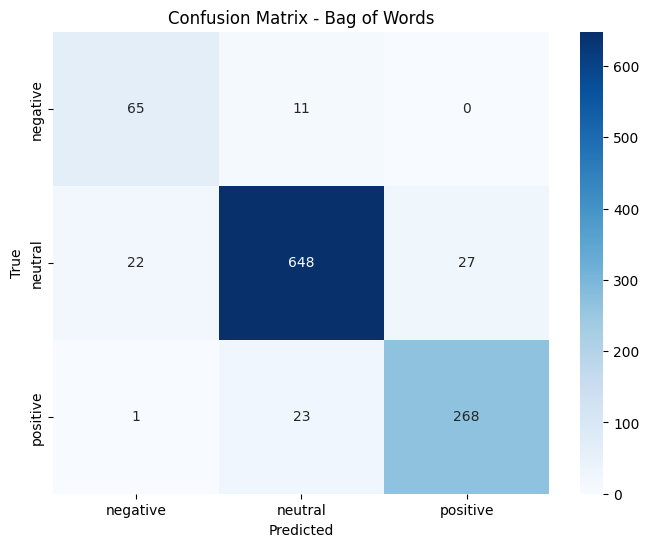

2025/09/09 17:46:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Top 10 important features for Bag of Words:
        feature  importance
1107      group    0.088332
2832         up    0.073684
680        down    0.051103
1471       loss    0.048327
2089     profit    0.045710
1242   increase    0.036441
1117     growth    0.028302
611   decreased    0.025096
2622     supply    0.021857
1245  increased    0.020869


2025/09/09 17:47:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/09 17:47:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/09 17:47:06 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/09/09 17:47:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run youthful-ant-633 at: http://ec2-43-205-211-96.ap-south-1.compute.amazonaws.com:5000/#/experiments/393294509303202776/runs/4c10ce7ff5a34a73b68f1c51bacd50ba
🧪 View experiment at: http://ec2-43-205-211-96.ap-south-1.compute.amazonaws.com:5000/#/experiments/393294509303202776


In [ ]:
# Bag of Words (BoW)
bow_vectorizer = CountVectorizer(max_features=3000, ngram_range=(1, 2), min_df=1, max_df=0.8)
print("Training Decision Tree with Bag of Words...")
dt_bow, bow_vec = train_evaluate_dt(bow_vectorizer, "Bag of Words")


Training Decision Tree with TF-IDF...

Best parameters for TF-IDF: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Results for TF-IDF:
Accuracy: 0.9136
Balanced Accuracy: 0.8899

Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.83      0.77        76
     neutral       0.95      0.92      0.93       697
    positive       0.89      0.92      0.91       292

    accuracy                           0.91      1065
   macro avg       0.85      0.89      0.87      1065
weighted avg       0.92      0.91      0.91      1065



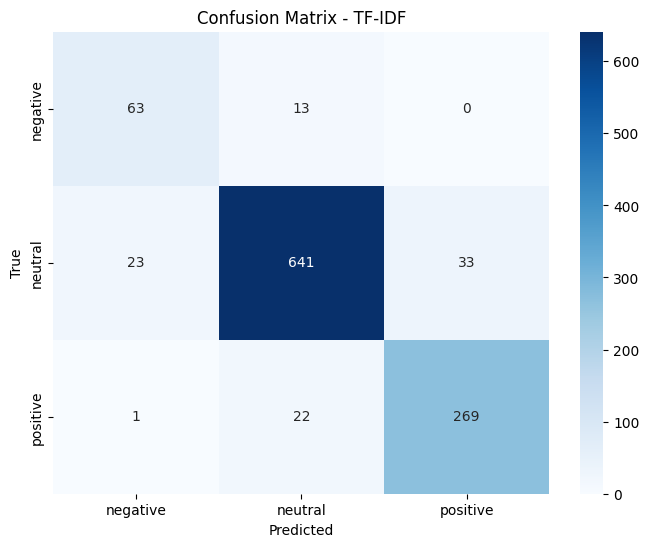

2025/09/09 17:50:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Top 10 important features for TF-IDF:
        feature  importance
1850      group    0.088300
4720         up    0.074028
1175       down    0.052182
2555       loss    0.047732
3439     profit    0.046019
2122   increase    0.036399
1877     growth    0.028316
1047  decreased    0.024446
4386     supply    0.021832
4389    support    0.019673


2025/09/09 17:51:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/09 17:51:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/09 17:51:02 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/09/09 17:51:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run shivering-donkey-912 at: http://ec2-43-205-211-96.ap-south-1.compute.amazonaws.com:5000/#/experiments/393294509303202776/runs/fe43a9541d32455da6cced2478cad976
🧪 View experiment at: http://ec2-43-205-211-96.ap-south-1.compute.amazonaws.com:5000/#/experiments/393294509303202776


In [26]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=1, max_df=0.8)
print("\nTraining Decision Tree with TF-IDF...")
dt_tfidf, tfidf_vec = train_evaluate_dt(tfidf_vectorizer, "TF-IDF")